In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
### importing packages
import os
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

import PIL
from PIL import ImageOps

from tensorflow import keras

from skimage.transform import resize
from keras.preprocessing.image import load_img
from IPython.display import Image, display


from keras.models import *
from keras import layers
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

import random

seed = 42
np.random.seed = seed

In [3]:
print(tf.__version__)

2.3.0


In [4]:
IMG_WIDTH_ORIGINAL=512
IMG_HEIGHT_ORIGINAL=1024
IMG_WIDTH = 256
IMG_HEIGHT = 512
IMG_CHANNELS = 1 # grayscale images
img_size = (IMG_HEIGHT, IMG_WIDTH)
num_classes = 8
batch_size = 4 # try 4, 8, 12, 16, 32


# paths to image folders 
train_images_path='/content/drive/My Drive/Colab Notebooks/IEEE/train_images'
train_mask_path='/content/drive/My Drive/Colab Notebooks/IEEE/train_masks'
val_images_path='/content/drive/My Drive/Colab Notebooks/IEEE/val_images'
val_mask_path='/content/drive/My Drive/Colab Notebooks/IEEE/val_masks'
test_images_path='/content/drive/My Drive/Colab Notebooks/IEEE/test_images'
test_mask_path='/content/drive/My Drive/Colab Notebooks/IEEE/test_masks'
train_preds_path ='/content/train_pred'
train_mask_path1 ='/content/train_mask'
val_preds_path = '/content/val_pred'
val_mask_path1 = '/content/val_mask'

Prepare paths of input images and target segmentation masks

In [5]:
input_train_paths = sorted(
    [
        os.path.join(train_images_path, fname)
        for fname in os.listdir(train_images_path)
        if fname.endswith(".png")
    ]
)

target_train_paths = sorted(
    [
        os.path.join(train_mask_path, fname)
        for fname in os.listdir(train_mask_path)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
print("Number of training samples:", len(input_train_paths))

input_val_paths = sorted(
    [
        os.path.join(val_images_path, fname)
        for fname in os.listdir(val_images_path)
        if fname.endswith(".png")
    ]
)

target_val_paths = sorted(
    [
        os.path.join(val_mask_path, fname)
        for fname in os.listdir(val_mask_path)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
print("Number of validation samples:", len(input_val_paths))

Number of training samples: 796
Number of validation samples: 170


Displaying images and masks


In [6]:
# colour definition
black = np.array([0, 0, 0, 255])
white = np.array([255, 255, 255, 255])
yellow = np.array([255, 255, 0, 255])
red = np.array([255, 0, 0, 255]) 
blue = np.array([0, 0, 255, 255])
light_blue = np.array([0, 255, 255, 255])
green = np.array([0, 255, 0, 255])
pink = np.array([255, 0, 255, 255]) 

# function which trasform mask values 0,1,2,3,4,5,6,7 into colours
def num_to_colors (mask, height, width):
    col_mask = np.zeros((height, width, 4))
    for j in range (0,width):
        for i in range (0,height):
            if (mask[i,j]==0):
                col_mask[i,j]=black
            elif (mask[i,j]==1):
                col_mask[i,j]= red
            elif (mask[i,j]==2):
                col_mask[i,j]=yellow
            elif (mask[i,j]==3):
                col_mask[i,j]=green
            elif (mask[i,j]==4):
                col_mask[i,j]=blue
            elif (mask[i,j]==5):
                col_mask[i,j]=light_blue
            elif (mask[i,j]==6):
                col_mask[i,j]=pink
            elif (mask[i,j]==7):
                col_mask[i,j]=white
           
    return col_mask

Image id: 92 scan(549).png



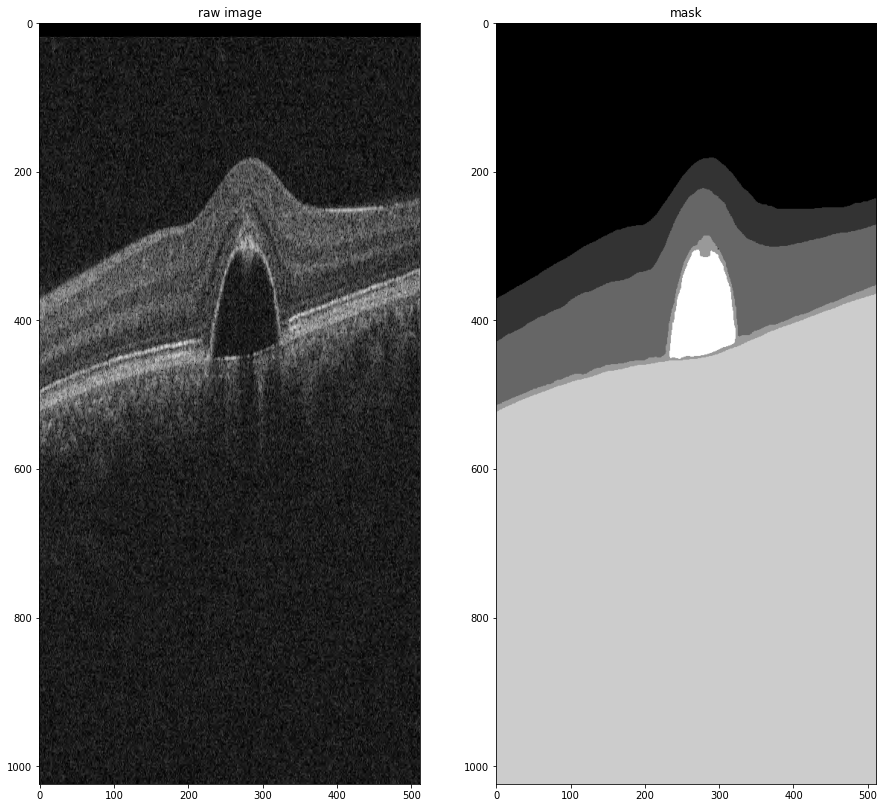

In [7]:
m=os.listdir(test_images_path)
i = np.random.randint(0,len(m))
print('Image id:', i ,  m[i])
print()
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title('raw image')
#raw = load_img(input_val_paths[i])
raw = PIL.ImageOps.autocontrast(load_img(input_train_paths[i]))
plt.imshow(raw)
plt.subplot(1, 2, 2)
plt.title('mask')
mask = PIL.ImageOps.autocontrast(load_img(target_train_paths[i]))
plt.imshow(mask)

plt.show()

Prepare Sequence class to load & vectorize batches of data

In [7]:
class OCT(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_train_paths, target_train_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_train_paths = input_train_paths
        self.target_train_paths = target_train_paths

    def __len__(self):
        return len(self.target_train_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_train_paths = self.input_train_paths[i : i + self.batch_size]
        batch_target_train_paths = self.target_train_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_input_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img=np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            x[j] = img
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            y[j] = img
        return x, y

Perpare U-Net Xception-style model

In [42]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

    
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
#model.summary()

In [43]:
#### in case of transfer learning - loading model
# load json and create model
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
os.chdir('/content/')
model.load_weights("model.h5")

In [44]:
### Instantiate data Sequences for each split
train_gen = OCT(
    batch_size, img_size, input_train_paths, target_train_paths
)
val_gen = OCT(batch_size, img_size, input_val_paths, target_val_paths)

Train the model

In [16]:
### Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("OCT_segmentation.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)
]

# Train the model, doing validation at the end of each epoch.
epochs = 100
model_history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/100
 96/199 [=============>................] - ETA: 9:35 - loss: 1.3670

KeyboardInterrupt: ignored

In [ ]:
model.compile(optimizer=Adam(lr=1e-5), loss="sparse_categorical_crossentropy")
epochs = 10
model_history = model.fit(train_gen, epochs=epochs, validation_data=val_gen)

In [ ]:
# saving model for later use
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [ ]:
# Plotting loss and validation loss
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(31)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

Visualize predictions

In [45]:
val_gen = OCT(batch_size, img_size, input_val_paths, target_val_paths)
val_preds = model.predict(val_gen)

In [13]:
print(np.shape(val_preds))


(168, 512, 256, 8)


In [14]:
fname=os.listdir(test_images_path)
os.chdir('/content/val_pred')
for i in range(0,168):
  
  img = val_preds[i]
  img = np.argmax(img, axis=-1)
  img = np.expand_dims(img, axis=-1)
  cv2.imwrite(fname[i], img)


In [15]:
os.chdir('/content/val_mask')
for i in range(0,168):
  img = load_img(target_val_paths[i], color_mode="grayscale")
  img = np.expand_dims(img, axis=-1)
  cv2.imwrite(fname[i], img)

In [22]:
train_preds = model.predict(train_gen)

In [ ]:
fname=os.listdir(train_images_path)
os.chdir('/content/train_pred')
for i in range(0,796):
  img = train_preds[i]
  img = np.argmax(img, axis=-1)
  img = np.expand_dims(img, axis=-1)
  cv2.imwrite(fname[i], img)
os.chdir('/content/train_mask')
for i in range(0,796):
  img = load_img(target_train_paths[i], color_mode="grayscale")
  img = np.expand_dims(img, axis=-1)
  cv2.imwrite(fname[i], img)

In [ ]:
 img = load_img(target_train_paths[1], color_mode="grayscale")
 img = np.expand_dims(img, axis=-1)
 #img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
 print(np.shape(img))

(1024, 512, 1)


In [ ]:
print(np.shape(val_preds))
print(np.shape(val_gen[0]))

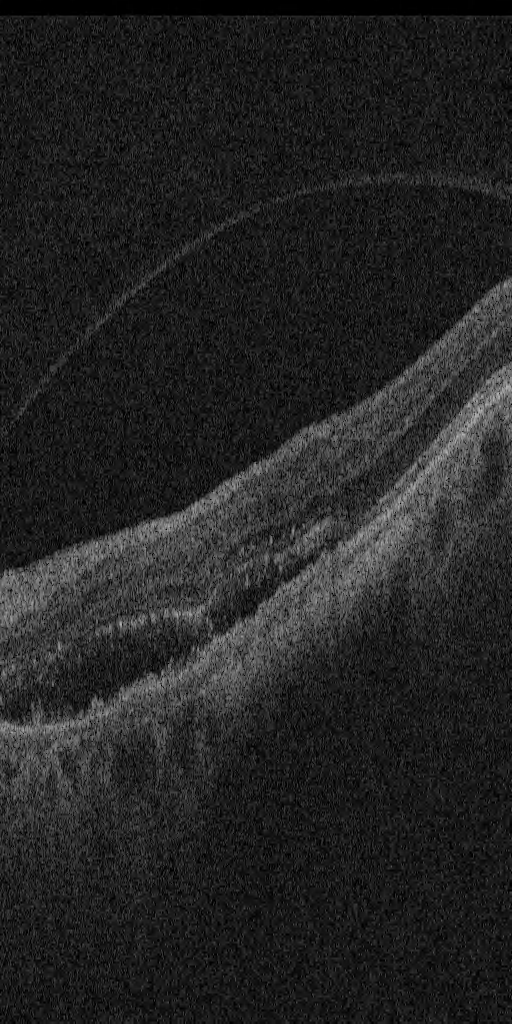

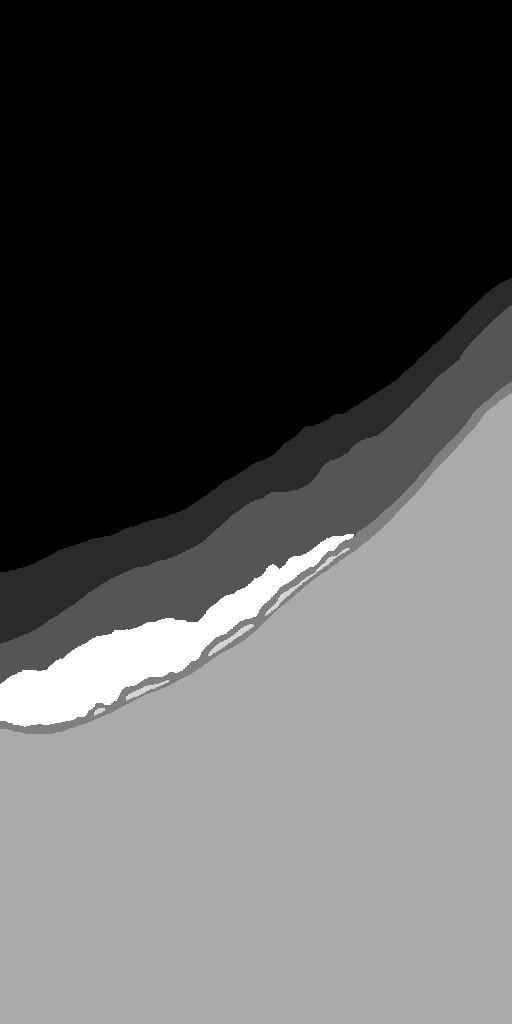

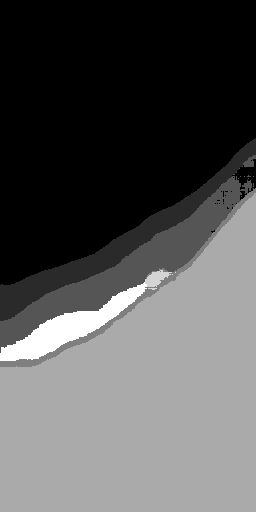

In [17]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #99
i = 99

# Display input image
display(Image(filename=input_val_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(target_val_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 512x256.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


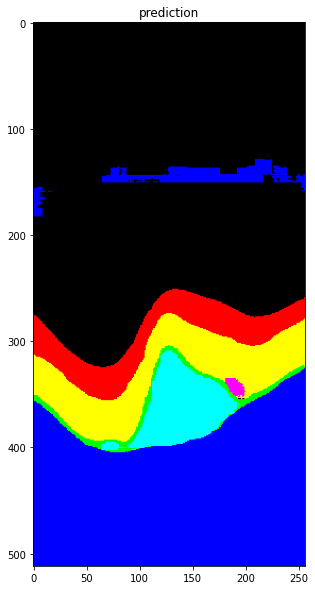

In [16]:
i=86
plt.figure(figsize=(10, 10))
plt.title('prediction')
pred = np.argmax(val_preds[i], axis=-1)
pred = np.expand_dims(pred, axis=-1)
pred = num_to_colors(pred, IMG_HEIGHT, IMG_WIDTH)
plt.imshow(pred)

plt.show()

Image id: 2 scan(970).png


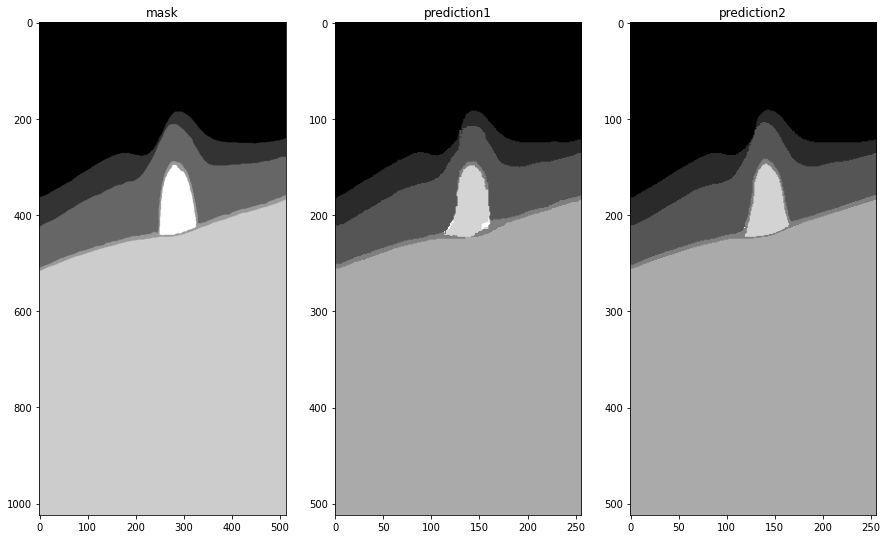

In [47]:
m=os.listdir(test_images_path)
i = np.random.randint(0,len(m))
i=2
print('Image id:', i ,  m[i])
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title('mask')
mask = PIL.ImageOps.autocontrast(load_img(target_val_paths[i]))
plt.imshow(mask)
plt.subplot(1, 3, 2)
plt.title('prediction1')
pred = PIL.ImageOps.autocontrast(load_img(input_val_paths[i]))
plt.imshow(pred)
plt.subplot(1, 3, 3)
plt.title('prediction2')
pred = np.argmax(val_preds[i], axis=-1)
pred = np.expand_dims(pred, axis=-1)
pred = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(pred))
plt.imshow(pred, cmap='gray')


plt.show()

Visualizing convnet filters


In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  x += 0.5
  x = np.clip(x, 0, 1)
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
def generate_pattern(layer_name, filter_index, size=64):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])
  grads = K.gradients(loss, model.input)[0]
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
  iterate = K.function([model.input], [loss, grads])
  input_img_data = np.random.random((1, size, size, 1)) * 20 + 128.
  step = 1.
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    img = input_img_data[0]
    img = np.reshape(img, (size, size))
  return deprocess_image(img)

In [ ]:
from keras import backend as K
# conv2d_ 2  4, 7  10  13 16
layer_name = 'conv2d_3'
size = 64
margin = 5
results = np.zeros((4 * size + 3 * margin, 4 * size + 3 * margin))

for i in range(4):
  for j in range(4):
    filter_img = generate_pattern(layer_name, i+(j*4), size=size)
    filter_img = np.reshape(filter_img, (size, size))
    horizontal_start = i * size + i * margin
    horizontal_end = horizontal_start + size
    vertical_start = j * size + j * margin
    vertical_end = vertical_start + size
    results[horizontal_start: horizontal_end, vertical_start: vertical_end] = filter_img

plt.figure(figsize=(10, 10))
plt.imshow(results, cmap='gray')

Confusion matrix

In [17]:
!pip install pycm

     |████████████████████████████████| 61kB 2.2MB/s 
     |████████████████████████████████| 552kB 8.8MB/s 


In [18]:
import pycm
from pycm import *

In [48]:
i= 0

mask = load_img(target_val_paths[i], target_size = img_size, color_mode="grayscale")
mask = np.reshape(mask, (IMG_HEIGHT, IMG_WIDTH, 1))

pred = np.argmax(val_preds[i], axis=-1)
pred = np.expand_dims(pred, axis=-1)

pred_vector=pred.flatten()
mask_vector=mask.flatten()

for i in range(1, 167):
  mask = load_img(target_val_paths[i], target_size = img_size, color_mode="grayscale")
  mask = np.reshape(mask, (IMG_HEIGHT, IMG_WIDTH, 1))    
  mask_vector = np.concatenate((mask_vector, mask.flatten()), axis=0)
  pred = np.argmax(val_preds[i], axis=-1)
  pred = np.expand_dims(pred, axis=-1)
  pred_vector = np.concatenate((pred_vector, pred.flatten()), axis=0)


In [49]:
cm = ConfusionMatrix(actual_vector=mask_vector, predict_vector=pred_vector)
cm.classes

[0, 1, 2, 3, 4, 5, 6, 7]

In [51]:
cm.save_csv(os.path.join("","cm2"))

{'Message': '/content/cm2.csv', 'Status': True}

In [131]:
#print(cm)

In [132]:
#print(cm.TI(0.5, 0.5))

In [123]:
#cm.print_matrix()

In [124]:
#cm.print_normalized_matrix()

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(mask_vector, pred_vector)

In [53]:
from sklearn.metrics import f1_score
print(f1_score(mask_vector, pred_vector, labels=[0,1,2,3,4,5,6,7], average=None))

[0.99348197 0.95339768 0.94430332 0.68340828 0.99681909 0.86613502
 0.89050344 0.69216308]


In [127]:
#print(cf_matrix)

In [54]:
cf_matrix_normal = cf_matrix.astype('float32') / cf_matrix.sum(axis=1)[:, np.newaxis]
#print(cf_matrix_normal )


In [55]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.2f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

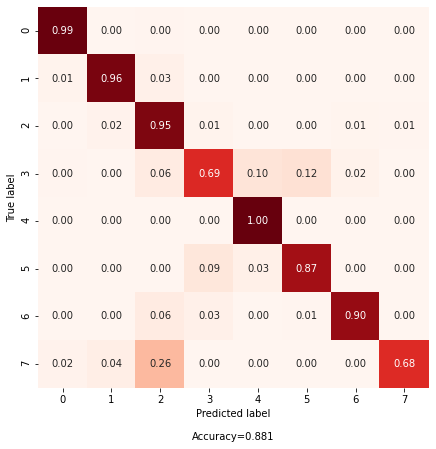

In [56]:
make_confusion_matrix(cf_matrix_normal, count = True, percent = False, figsize=(7,7), cbar=False, cmap='Reds')

In [57]:
print(f1_score(mask_vector, pred_vector, labels=[0,1,2,3,4,5,6,7], average=None))

[0.99348197 0.95339768 0.94430332 0.68340828 0.99681909 0.86613502
 0.89050344 0.69216308]


In [65]:
dice = np.zeros((168,1))
for i in range(0, 167):
  mask = load_img(target_val_paths[i], target_size = img_size, color_mode="grayscale")
  mask = np.reshape(mask, (IMG_HEIGHT, IMG_WIDTH, 1))    
  mask_vector=mask.flatten()
  pred = np.argmax(val_preds[i], axis=-1)
  pred = np.expand_dims(pred, axis=-1)
  pred_vector=pred.flatten()
  dice[i] = f1_score(mask_vector, pred_vector, labels=[7], average=None, zero_division=1)

print(np.mean(dice), np.std(dice))

0.8921094247840747 0.2807728999230076
